In [1]:
import json

import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from IPython.display import HTML, display
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 100

# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 80%; }
#     div#menubar-container     { width: 80%; }
#     div#maintoolbar-container { width: 80%; }
# </style>
# """))

pd.options.mode.chained_assignment = None

In [2]:
seed = 21

# Funções auxiliares

In [3]:
def plot_map(
    df,
    column_cluster="cluster",
    icons_cluster_colors=False,
    deliverymen=True,
    zoom_start=7,
):
    
    colors = ['blue','red','green','orange','pink','black','lightblue','purple','gray','cadetblue']
    
    cmap = cm.LinearColormap(colors=colors,
                             vmin=np.min(df[column_cluster]),
                             vmax=np.max(df[column_cluster]),
                             caption = 'Cluster Labels'
                            )

    center = [np.mean([np.mean(df.customer_lat), np.mean(df.seller_lat),]),
              np.mean([np.mean(df.customer_lng), np.mean(df.seller_lng),]),
             ]
    
    map_sp = folium.Map(location=center, zoom_start=zoom_start, width='100%', height="100%")

    for index, d in df.iterrows():
        
        location_origem = [d['seller_lat'], d['seller_lng']]
        location_destino = [d['customer_lat'], d['customer_lng']]
        if deliverymen:
            location_deliveryman = [d['deliveryman_lat'], d['deliveryman_lng']]

        folium.Marker(location_origem,
                      popup='origem',
                      icon=folium.Icon(color=colors[d[column_cluster]] if icons_cluster_colors else 'green'),
                     ).add_to(map_sp)

        folium.Marker(location_destino,
                      popup='destino',
                      icon=folium.Icon(color=colors[d[column_cluster]] if icons_cluster_colors else 'blue'),
                     ).add_to(map_sp)

        folium.PolyLine([location_origem, location_destino],
                        weight=2.5,
                        color=cmap(d[column_cluster]),
                       ).add_to(map_sp)
        
        if deliverymen:
            folium.Marker(location_deliveryman,
                          popup=f'Delivery Man: {d["id_deliveryman"]}',
                          icon=folium.Icon("red"),
                         ).add_to(map_sp)

    if deliverymen:
        legend_html =   f'''
                        <div style="position: fixed; 
                                    bottom: 50px; right: 50px; width: 150px; height: 115px;
                                    border:2px solid grey; z-index:9999; font-size:14px;
                                    ">&nbsp; Legend <br>
                                      &nbsp; Origin &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                                      &nbsp; Destination &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                                      &nbsp; Deliveryman &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                        </div>
                        '''
    else:
        legend_html =   f'''
                        <div style="position: fixed; 
                                    bottom: 50px; right: 50px; width: 150px; height: 90px; 
                                    border:2px solid grey; z-index:9999; font-size:14px;
                                    ">&nbsp; Legend <br>
                                      &nbsp; Origin &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                                      &nbsp; Destination &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
                        </div>
                        '''

    map_sp.get_root().html.add_child(folium.Element(legend_html))

    map_sp.add_child(cmap)
    
    display(map_sp)

In [4]:
def _convertVolume(df, col_name):
    df[col_name] = np.where(
        df.isin({col_name: ["Alta", "Grande"]})[col_name],
        0,
        np.where(
            df.isin({col_name: ["Média", "Médio"]})[col_name],
            1,
            np.where(df.isin({col_name: ["Baixa", "Pequeno"]})[col_name], 2, -1),
        ),
    )
    return df

# Preparação das bases

In [5]:
path = ".//Bases//01.Montagem_da_Base"

### Ordens

In [6]:
ordens = pd.read_csv(f"{path}//orders.csv")

vendedores_geo = (
    pd.read_csv(f"{path}//sellers_geolocation.csv")
    .rename(
        columns={
            "geolocation_lat":"seller_lat",
            "geolocation_lng":"seller_lng",
        }
    )
    [["seller_id", "seller_lat", "seller_lng",]]
    .set_index("seller_id")
)

clientes_geo = (
    pd.read_csv(f"{path}//customer_geolocations.csv")
    .rename(
        columns={
            "geolocation_lat":"customer_lat",
            "geolocation_lng":"customer_lng",
        }
    )
    [["customer_id", "customer_lat", "customer_lng",]]
    .set_index("customer_id")
)

ordens = (
    ordens
    .join(other=vendedores_geo, on="seller_id", how="inner")
    .join(other=clientes_geo, on="customer_id", how="inner")
    [[
        "order_id",
        "volume",
        "seller_lat", "seller_lng",
        "customer_lat", "customer_lng",
    ]]
)

ordens

,order_id,volume,seller_lat,seller_lng,customer_lat,customer_lng
0,93ec3e2c9a4beee38c28973d307093e1,Alta,-22.397009,-46.945452,-23.468541,-46.664361
540,e39cc0368ca2a9ce8244880519c3b2ad,Alta,-22.397009,-46.945452,-23.450088,-46.611040
573,65f3fd49c769a2d6de1aba25b6a5b8d0,Alta,-22.397009,-46.945452,-23.715871,-46.413099
1045,93b3fec4ab5648e985ee7e781e0e1b6d,Alta,-22.397009,-46.945452,-23.532571,-46.549700
1159,ed09706e867828c762e46ad418d064d7,Alta,-22.397009,-46.945452,-23.486058,-46.628199
...,...,...,...,...,...,...
2679,b976379b0ba072030d6d1aba2f370d7b,Baixa,-23.406989,-46.742792,-23.598747,-46.638424
2681,7f13340e916ed8270e11c9e840317f98,Baixa,-23.453618,-46.479821,-23.424512,-46.353605
2682,7ca7bb0f6b6d3ff38dbb91aec21a0e62,Média,-23.128521,-46.568223,-23.642064,-46.601161
2692,9afb4dbb97ba2e4b69f72df48c4cf901,Baixa,-23.444980,-46.456731,-23.945401,-46.391580


### Entregadores

In [7]:
entregadores = (
    pd.read_csv(f"{path}//deliveryman_geolocations.csv")
    .rename(
        columns={
            "geolocation_lat":"deliveryman_lat",
            "geolocation_lng":"deliveryman_lng",
        }
    )
    [["deliveryman_id", "deliveryman_lat", "deliveryman_lng", "car_capacity__c"]]
    .set_index("deliveryman_id")
)
entregadores

,deliveryman_lat,deliveryman_lng,car_capacity__c
deliveryman_id,,,
254705,-24.006472,-46.272175,Média
284178,-23.115526,-46.552918,Média
122019,-23.407401,-46.758610,Média
165215,-23.415004,-46.897116,Alta
86788,-23.630328,-46.640746,Alta
96477,-23.595924,-46.669864,Baixa
212140,-23.554467,-46.308525,Alta
227795,-23.666131,-46.413293,Alta
82413,-23.597327,-46.595990,Média


# Experimentação inicial

- 100 entregas
- 10 clusters (nr de entregadores)

In [15]:
nr_entregas = 100
nr_clusters = 10

sample = ordens.sample(n=nr_entregas, random_state=seed)

features = (
    sample
    [[
        "seller_lat",
        "seller_lng",
        "customer_lat",
        "customer_lng",
        "volume",
    ]]
)

features = _convertVolume(df=features, col_name="volume")

km = KMeans(n_clusters=nr_clusters, random_state=seed)
km.fit(features)

sample["cluster"] = km.labels_

print("\nsilhouette_score:", silhouette_score(X=features, labels=km.labels_))

sample.head(5)


silhouette_score: 0.47470307831965075


,order_id,volume,seller_lat,seller_lng,customer_lat,customer_lng,cluster
486,317bc187384c65775ea8f3b23aad4acf,Baixa,-22.556606,-47.442603,-23.665931,-47.029936,6
1254,47999a7490ff2905f7ca3da2edcc9c52,Baixa,-23.690136,-46.704876,-23.448542,-46.597961,2
2527,db8f21db0519c6ab351e3bbf641439ca,Baixa,-23.500717,-46.589716,-22.869819,-48.456964,7
927,8f815207602f16cdf25a3fb1858ca6be,Baixa,-23.304322,-45.977171,-23.854365,-46.954536,2
1294,eaae3cf15cb2de079d33c44d3a8b2dc9,Baixa,-23.736102,-46.441666,-23.582304,-46.403328,2


In [19]:
sample.groupby("cluster").agg(nr_orders=pd.NamedAgg("order_id","count"))

,nr_orders
cluster,
0,4
1,3
2,42
3,4
4,8
5,5
6,16
7,9
8,2


In [9]:
%matplotlib inline

for c in range(10):
    print(f"cluster {c}")
    plot_map(df=sample.query(f"cluster == {c}"), deliverymen=False, icons_cluster_colors=False)

cluster 0


cluster 1


cluster 2


cluster 3


cluster 4


cluster 5


cluster 6


cluster 7


cluster 8


cluster 9


In [11]:
plot_map(df=sample.query("cluster in [0,1,9]"), icons_cluster_colors=True, deliverymen=False)

In [13]:
plot_map(df=sample.query("cluster in [0,1,9]"), icons_cluster_colors=False, deliverymen=False)

In [14]:
plot_map(df=sample.query("cluster in [2, 8]"), icons_cluster_colors=True, deliverymen=False)

# Experimentação com valores aleatórios

In [11]:
scores = list()
iteracoes = 10000

for i in range(iteracoes):
    
    # entre 2 e 10 entregadores
    nr_clusters = random.randint(2, 10)
    
    # nr mínimo de entregas: nr de entregadores + 1
    # nr máximo de entregas: nr de entregadores * 10
    nr_entregas = random.randint(nr_clusters+1, nr_clusters * 10)
    
#     print(f"""nr_clusters: {nr_clusters} | nr_entregas: {nr_entregas}""")
    
    sample = ordens.sample(n=nr_entregas, random_state=seed)

    features = (
        sample
        [[
            "seller_lat",
            "seller_lng",
            "customer_lat",
            "customer_lng",
            "volume",
        ]]
    )

    features = _convertVolume(df=features, col_name="volume")

    km = KMeans(n_clusters=nr_clusters, random_state=seed)
    km.fit(features)

    km.labels_
    
    score = silhouette_score(X=features, labels=km.labels_)
    
    d = {
        "nr_clusters":nr_clusters,
        "nr_entregas":nr_entregas,
        "silhouette_score":score
    } 
    scores.append(d)

In [12]:
df_scores = pd.DataFrame(scores)
df_scores.head(5)

,nr_clusters,nr_entregas,silhouette_score
0,9,79,0.473492
1,7,48,0.463765
2,5,50,0.475162
3,4,25,0.503761
4,5,30,0.464959


In [13]:
df_scores.describe()

,nr_clusters,nr_entregas,silhouette_score
count,10000.000000,10000.000000,10000.000000
mean,5.976500,33.289500,0.443394
std,2.584882,21.995028,0.078879
min,2.000000,3.000000,0.030359
25%,4.000000,15.000000,0.426761
50%,6.000000,28.000000,0.462373
75%,8.000000,47.000000,0.483155
max,10.000000,100.000000,0.563992


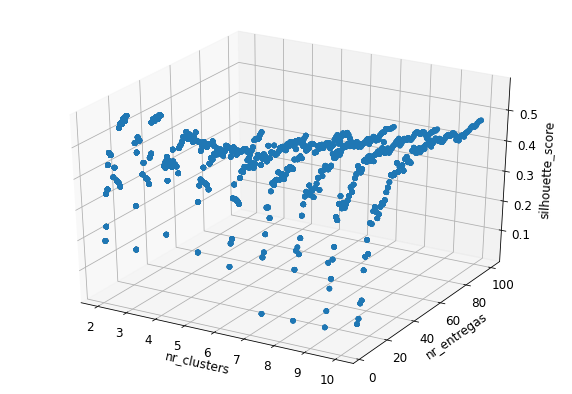

In [14]:
plt.figure(figsize=(10, 7))
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12

ax = plt.axes(projection='3d')

x = "nr_clusters"
y = "nr_entregas"
z = "silhouette_score"

ax.scatter3D(df_scores[x], df_scores[y], df_scores[z])

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

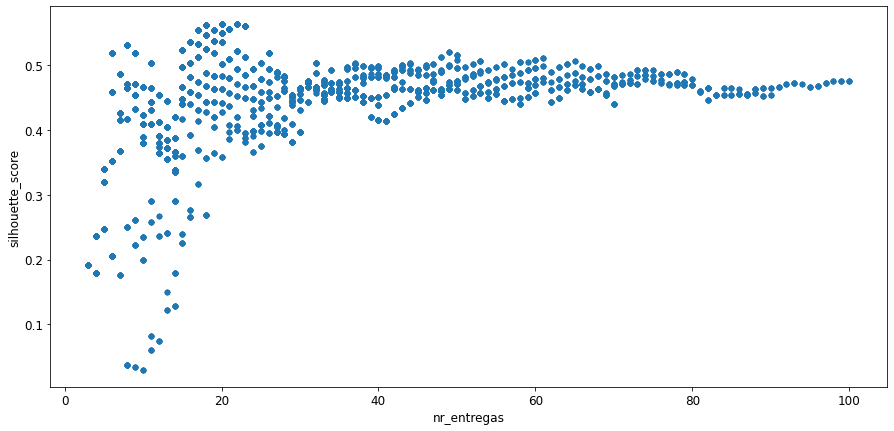

In [15]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
df_scores.plot.scatter("nr_entregas", "silhouette_score", figsize=(15,7))

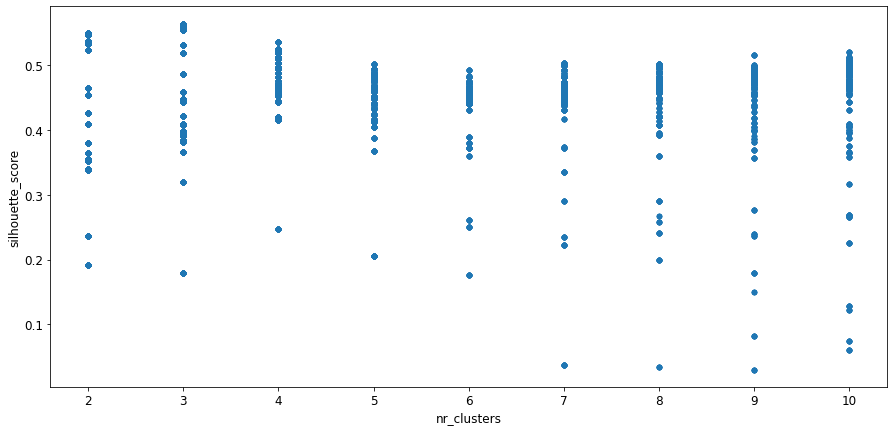

In [16]:
df_scores.plot.scatter("nr_clusters", "silhouette_score", figsize=(15,7))